
Training Size: 6 Samples (All TF)
Evaluating feature subset: RO1-RO4
Evaluating feature subset: RO5-RO8
Evaluating feature subset: All Features

Summary of Results:
  Feature Subset  Accuracy  Precision  Recall
0        RO1-RO4  0.084249   0.007937     1.0
1        RO5-RO8  0.080586   0.007905     1.0
2   All Features  0.081807   0.007916     1.0


<Figure size 1000x600 with 0 Axes>

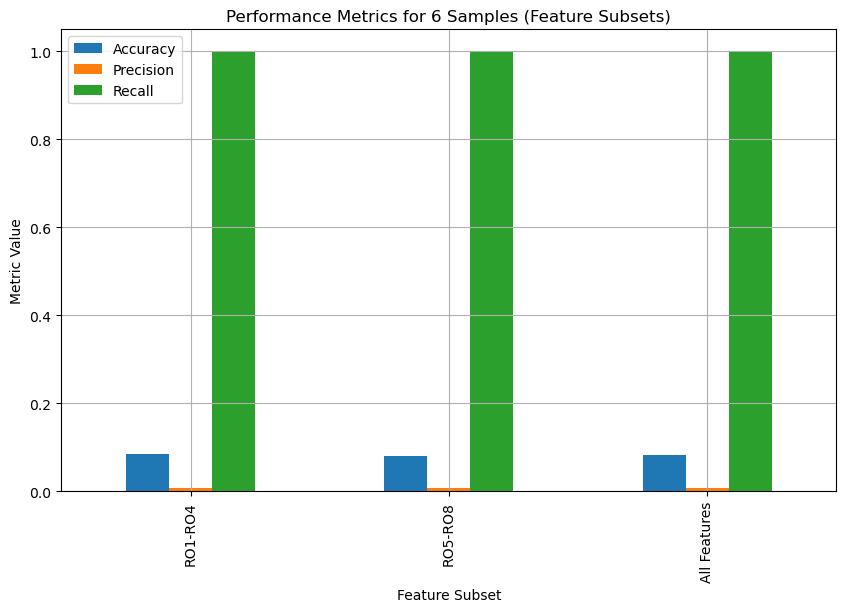


Training Size: 12 Samples (All TF)
Evaluating feature subset: RO1-RO4
Evaluating feature subset: RO5-RO8
Evaluating feature subset: All Features

Summary of Results:
  Feature Subset  Accuracy  Precision  Recall
0        RO1-RO4  0.081181   0.015810     1.0
1        RO5-RO8  0.082411   0.015831     1.0
2   All Features  0.081181   0.015810     1.0


<Figure size 1000x600 with 0 Axes>

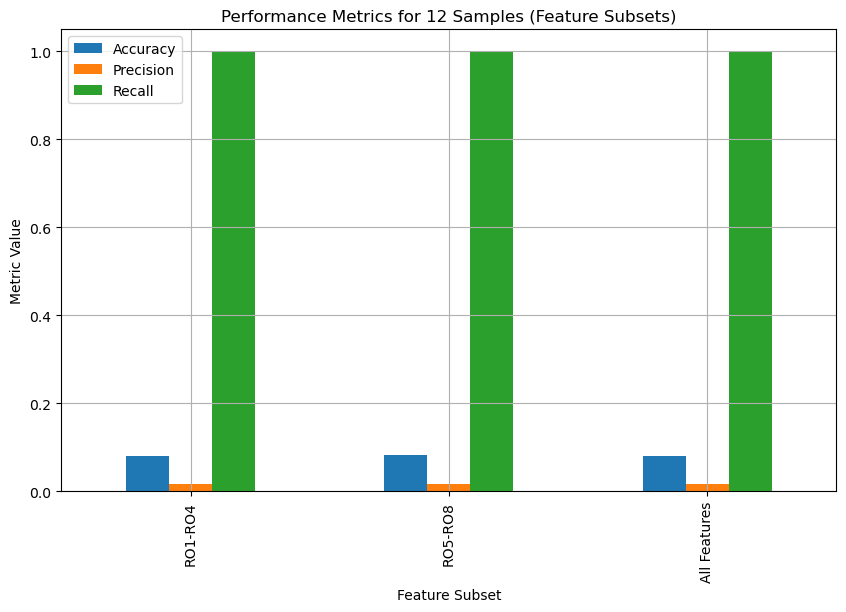


Training Size: 24 Samples (All TF)
Evaluating feature subset: RO1-RO4
Evaluating feature subset: RO5-RO8
Evaluating feature subset: All Features

Summary of Results:
  Feature Subset  Accuracy  Precision    Recall
0        RO1-RO4  0.896380   0.016393  0.041667
1        RO5-RO8  0.902622   0.017857  0.041667
2   All Features  0.897628   0.016667  0.041667


<Figure size 1000x600 with 0 Axes>

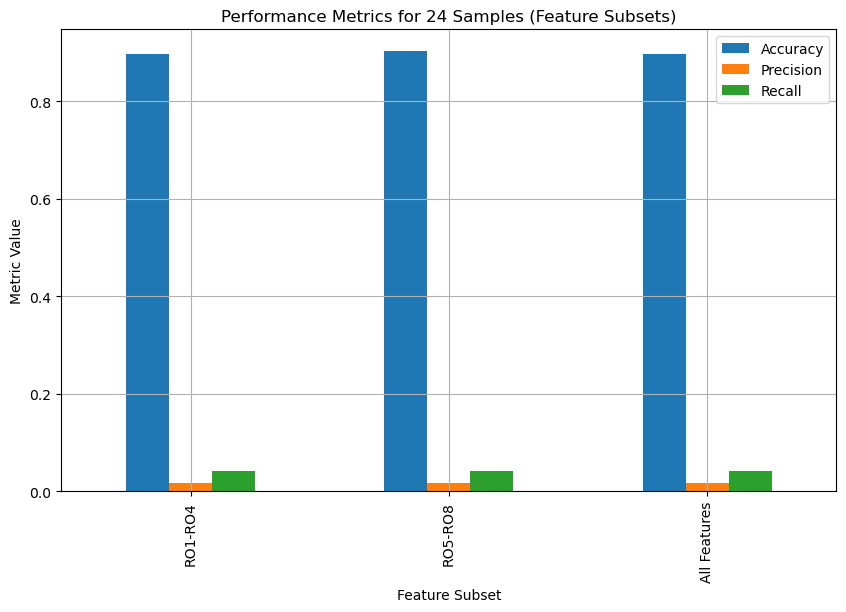

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load all files and extract data
def load_data(file_pattern="ROFreq/Chip*.xlsx"):
    from glob import glob
    files = glob(file_pattern)
    data = {}
    for file in files:
        chip_name = file.split("/")[-1].split(".")[0]
        data[chip_name] = pd.read_excel(file, header=None)
    return data

# Step 2: Extract golden data (rows 1 and 25) and prepare training/testing datasets
def prepare_data(data, num_samples):
    tf_samples = []  # Trojan-Free samples (row 1 and 25 from each file)
    test_samples = []  # All other rows for testing
    
    for chip, df in data.items():
        tf_samples.append(df.iloc[0].values)
        tf_samples.append(df.iloc[24].values)
        test_samples.append(df.drop([0, 24]).values)
    
    tf_samples = np.vstack(tf_samples)
    test_samples = np.vstack(test_samples)
    
    # Randomly select num_samples TF samples for training
    rng = np.random.default_rng(seed=42)  # Set seed for reproducibility
    selected_indices = rng.choice(tf_samples.shape[0], size=num_samples, replace=False)
    train_samples = tf_samples[selected_indices]
    remaining_indices = list(set(range(tf_samples.shape[0])) - set(selected_indices))
    test_samples = np.vstack([test_samples, tf_samples[remaining_indices]])
    
    return train_samples, test_samples

# Step 3: Train Isolation Forest and evaluate
def train_and_evaluate(train_samples, test_samples, feature_indices):
    # Subset features
    train_samples = train_samples[:, feature_indices]
    test_samples = test_samples[:, feature_indices]
    
    clf = IsolationForest(random_state=42, contamination=0.2, n_estimators=1500)
    clf.fit(train_samples)
    
    # Predict
    y_pred = clf.predict(test_samples)
    y_true = np.concatenate([np.ones(len(train_samples)), -np.ones(len(test_samples) - len(train_samples))])
    y_pred = np.where(y_pred == 1, 1, -1)
    
    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    
    return accuracy, precision, recall

# Step 4: Experiment with feature subsets
def experiment_with_features(data, num_samples, trials=20):
    feature_subsets = {
        "RO1-RO4": [0, 1, 2, 3],
        "RO5-RO8": [4, 5, 6, 7],
        "All Features": list(range(8))
    }
    
    results = []
    
    for subset_name, feature_indices in feature_subsets.items():
        print(f"Evaluating feature subset: {subset_name}")
        subset_metrics = {"Feature Subset": subset_name}
        
        acc_list, prec_list, rec_list = [], [], []
        for _ in range(trials):
            train_samples, test_samples = prepare_data(data, num_samples)
            acc, prec, rec = train_and_evaluate(train_samples, test_samples, feature_indices)
            acc_list.append(acc)
            prec_list.append(prec)
            rec_list.append(rec)
        
        # Average metrics
        subset_metrics["Accuracy"] = np.mean(acc_list)
        subset_metrics["Precision"] = np.mean(prec_list)
        subset_metrics["Recall"] = np.mean(rec_list)
        
        results.append(subset_metrics)
    
    return pd.DataFrame(results)

# Step 5: Main execution
def main():
    # Load data
    data = load_data()
    
    # Experiment for 6, 12, 24 samples (Case 2: All Trojan-Free)
    sample_groupings = [6, 12, 24]
    for num_samples in sample_groupings:
        print(f"\nTraining Size: {num_samples} Samples (All TF)")
        results_df = experiment_with_features(data, num_samples)
        print("\nSummary of Results:")
        print(results_df)
        
        # Visualize Results
        plt.figure(figsize=(10, 6))
        results_df.set_index("Feature Subset")[["Accuracy", "Precision", "Recall"]].plot(kind="bar", figsize=(10, 6))
        plt.title(f"Performance Metrics for {num_samples} Samples (Feature Subsets)")
        plt.ylabel("Metric Value")
        plt.grid(True)
        plt.show()

# Run the main function
main()



Training Size: 6 Samples (All TF)
Evaluating feature subset: RO1-RO4
Evaluating feature subset: RO5-RO8
Evaluating feature subset: All Features

Summary of Results:
  Feature Subset  Accuracy  Precision  Recall  Training Samples
0        RO1-RO4  0.084249   0.007937     1.0                 6
1        RO5-RO8  0.080586   0.007905     1.0                 6
2   All Features  0.081807   0.007916     1.0                 6


<Figure size 1000x600 with 0 Axes>

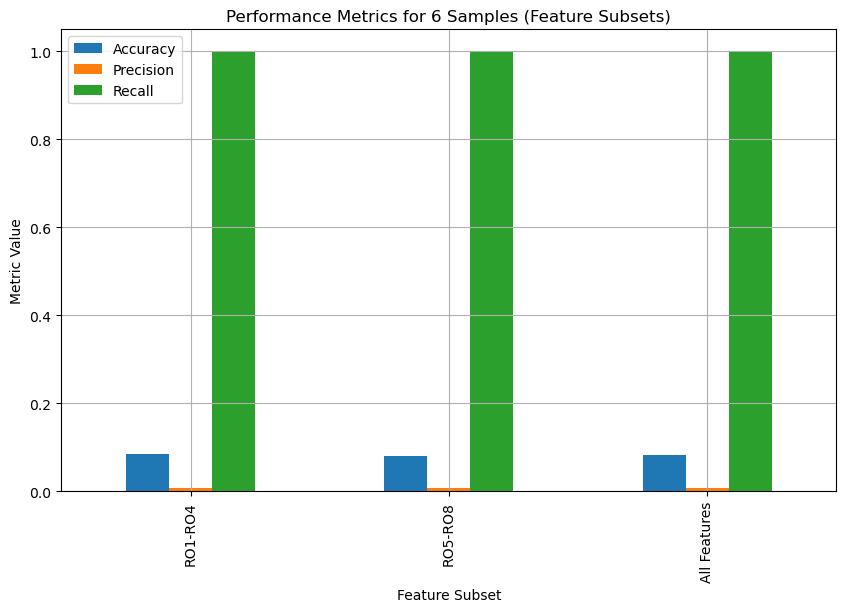


Training Size: 12 Samples (All TF)
Evaluating feature subset: RO1-RO4
Evaluating feature subset: RO5-RO8
Evaluating feature subset: All Features

Summary of Results:
  Feature Subset  Accuracy  Precision  Recall  Training Samples
0        RO1-RO4  0.081181   0.015810     1.0                12
1        RO5-RO8  0.082411   0.015831     1.0                12
2   All Features  0.081181   0.015810     1.0                12


<Figure size 1000x600 with 0 Axes>

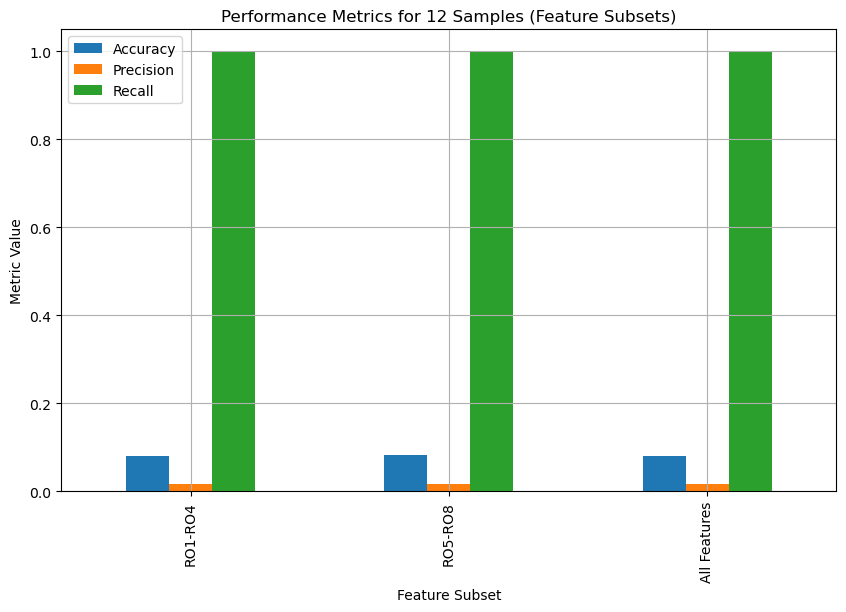


Training Size: 24 Samples (All TF)
Evaluating feature subset: RO1-RO4
Evaluating feature subset: RO5-RO8
Evaluating feature subset: All Features

Summary of Results:
  Feature Subset  Accuracy  Precision    Recall  Training Samples
0        RO1-RO4  0.896380   0.016393  0.041667                24
1        RO5-RO8  0.902622   0.017857  0.041667                24
2   All Features  0.897628   0.016667  0.041667                24


<Figure size 1000x600 with 0 Axes>

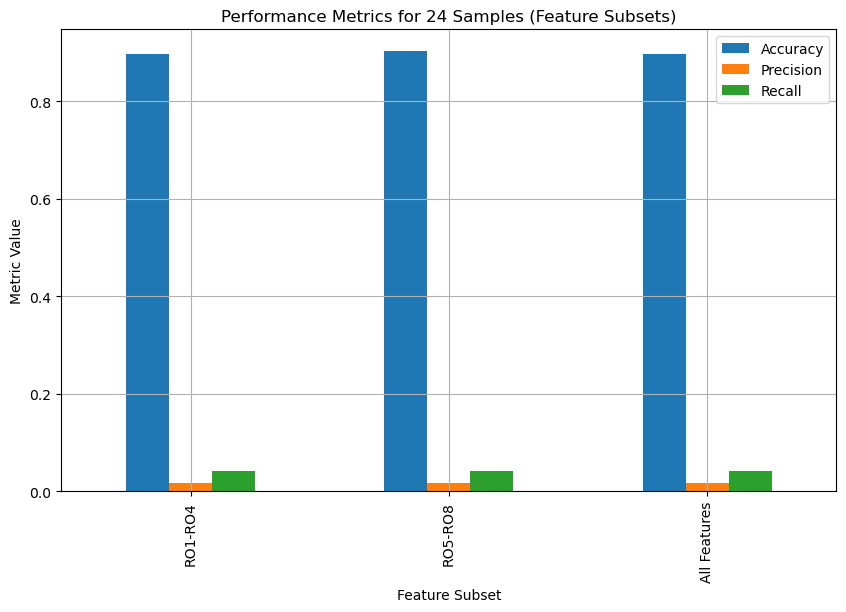


Combined Results:
  Feature Subset  Accuracy  Precision    Recall  Training Samples
0        RO1-RO4  0.084249   0.007937  1.000000                 6
1        RO5-RO8  0.080586   0.007905  1.000000                 6
2   All Features  0.081807   0.007916  1.000000                 6
3        RO1-RO4  0.081181   0.015810  1.000000                12
4        RO5-RO8  0.082411   0.015831  1.000000                12
5   All Features  0.081181   0.015810  1.000000                12
6        RO1-RO4  0.896380   0.016393  0.041667                24
7        RO5-RO8  0.902622   0.017857  0.041667                24
8   All Features  0.897628   0.016667  0.041667                24

Boxplot for Accuracy:


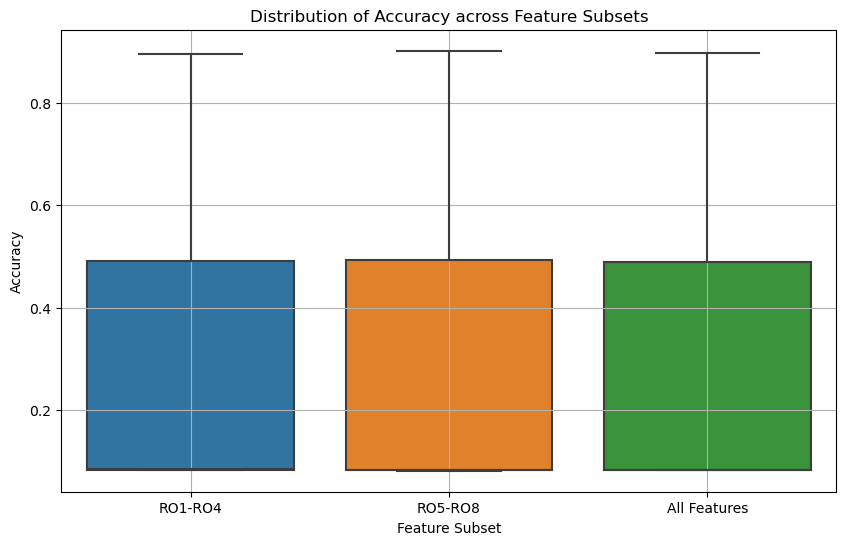


Boxplot for Precision:


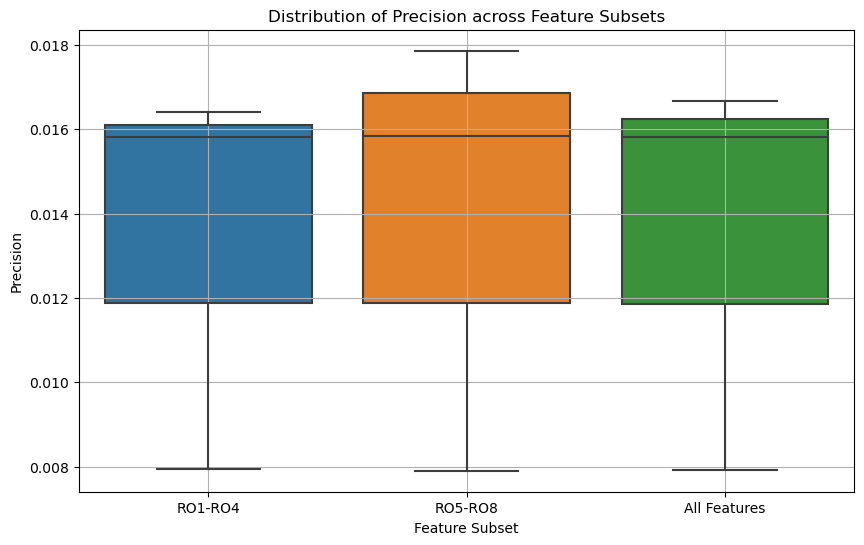


Boxplot for Recall:


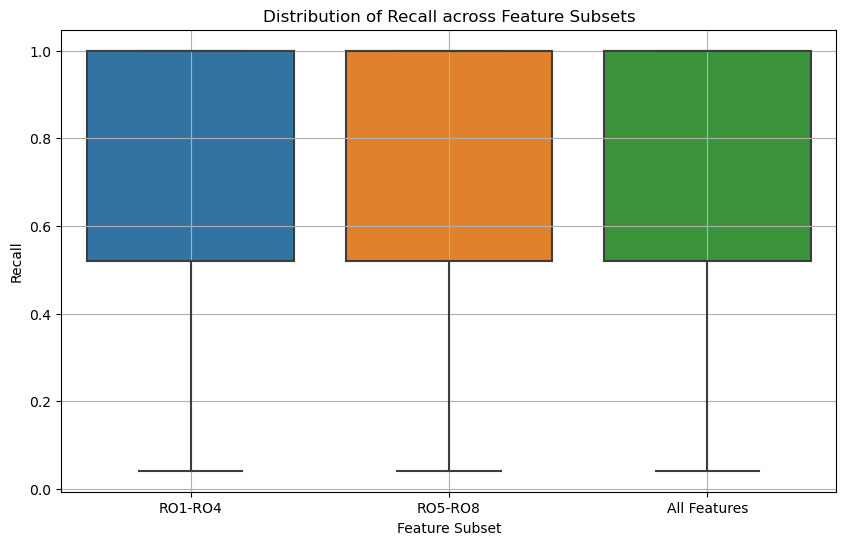


Heatmap of Accuracy:


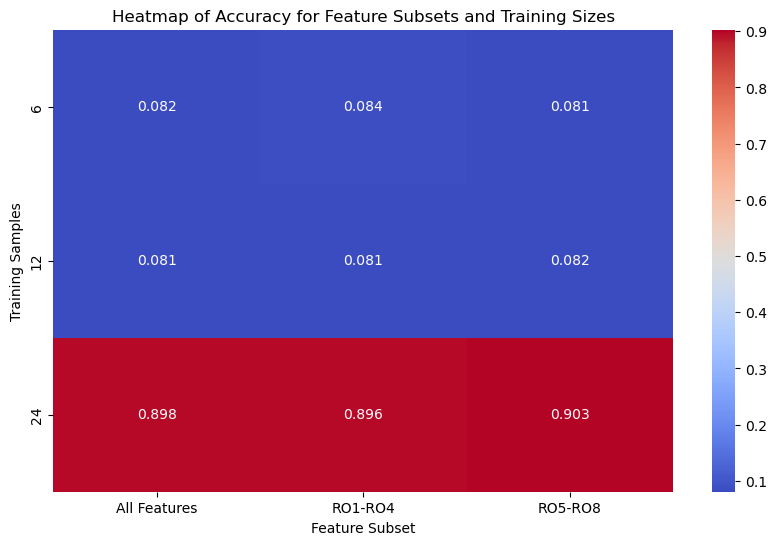


Heatmap of Precision:


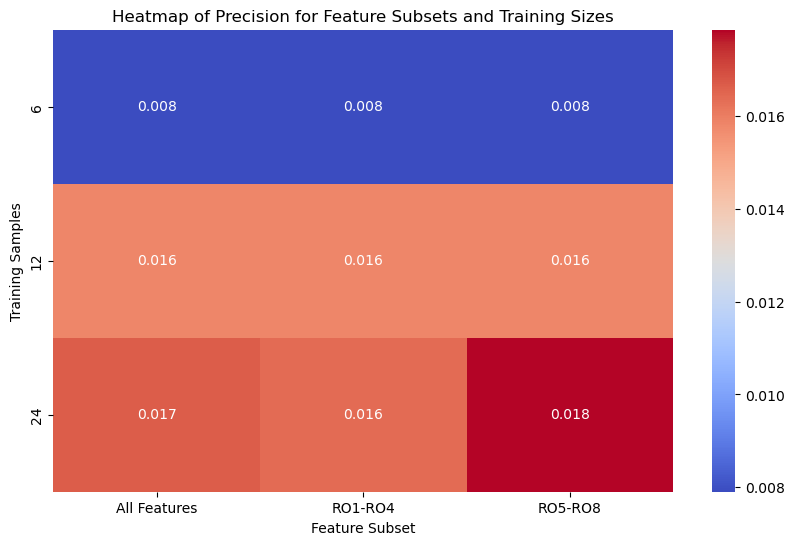


Heatmap of Recall:


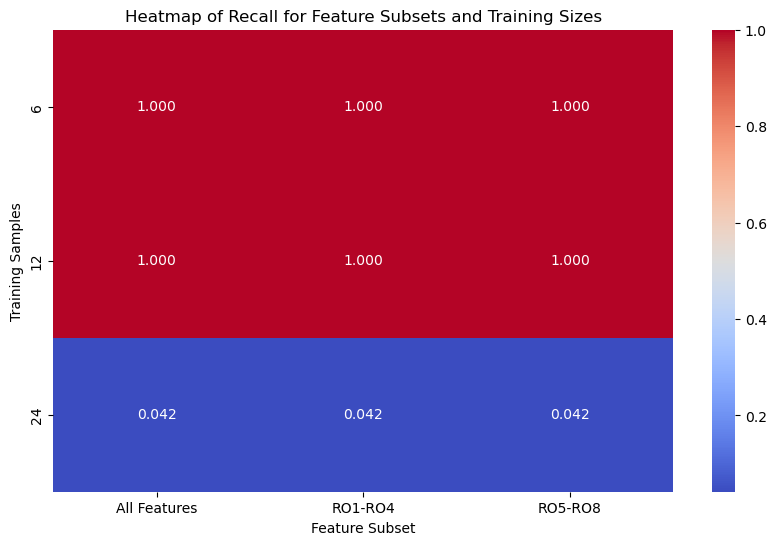


Line Plot for Metric Trends:


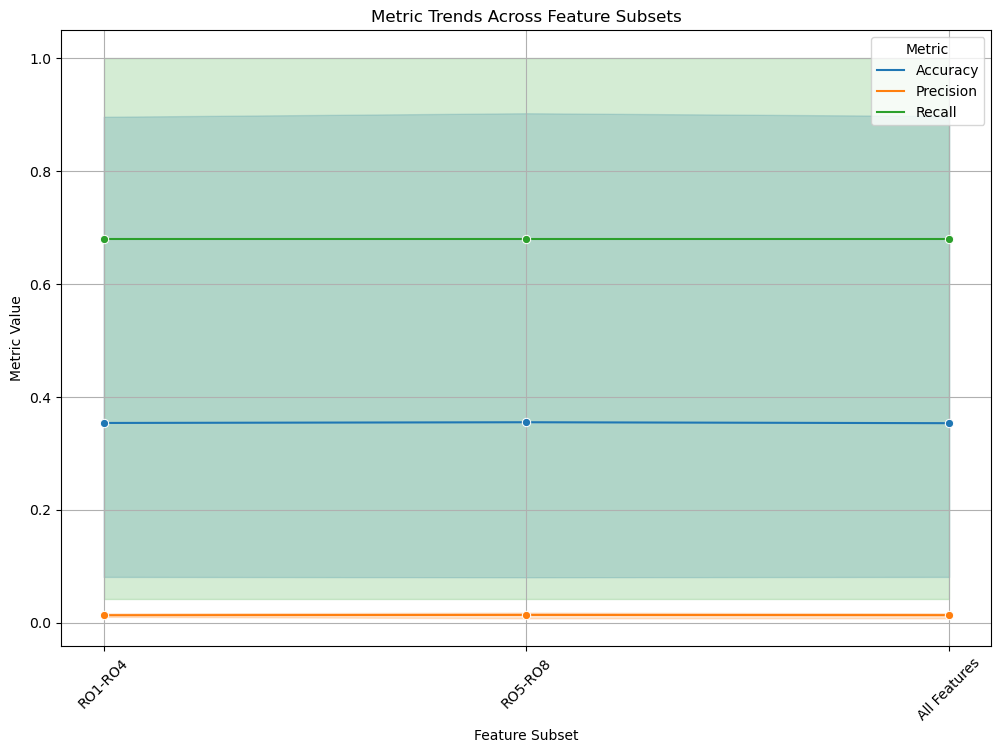

In [4]:
# Additional Visualization: Boxplots for Metrics across Feature Subsets
def plot_boxplots(results_df, metric_name):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=results_df, x="Feature Subset", y=metric_name)
    plt.title(f"Distribution of {metric_name} across Feature Subsets")
    plt.xlabel("Feature Subset")
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.show()

# Additional Visualization: Heatmap of Metrics
def plot_heatmap(results_df, metric):
    pivot_data = results_df.pivot(index="Training Samples", columns="Feature Subset", values=metric)
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_data, annot=True, cmap="coolwarm", fmt=".3f")
    plt.title(f"Heatmap of {metric} for Feature Subsets and Training Sizes")
    plt.ylabel("Training Samples")
    plt.xlabel("Feature Subset")
    plt.show()

# Additional Visualization: Line Plot for Metric Trends
def plot_metric_trends(results_df):
    melted_df = results_df.melt(id_vars=["Feature Subset"], 
                                value_vars=["Accuracy", "Precision", "Recall"], 
                                var_name="Metric", value_name="Value")
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=melted_df, x="Feature Subset", y="Value", hue="Metric", marker="o")
    plt.title("Metric Trends Across Feature Subsets")
    plt.ylabel("Metric Value")
    plt.xlabel("Feature Subset")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# Include Visualizations in Main Execution
def visualize_results(results_df):
    print("\nBoxplot for Accuracy:")
    plot_boxplots(results_df, "Accuracy")
    
    print("\nBoxplot for Precision:")
    plot_boxplots(results_df, "Precision")
    
    print("\nBoxplot for Recall:")
    plot_boxplots(results_df, "Recall")
    
    print("\nHeatmap of Accuracy:")
    plot_heatmap(results_df, "Accuracy")
    
    print("\nHeatmap of Precision:")
    plot_heatmap(results_df, "Precision")
    
    print("\nHeatmap of Recall:")
    plot_heatmap(results_df, "Recall")
    
    print("\nLine Plot for Metric Trends:")
    plot_metric_trends(results_df)

# Adjusted Main Function
def main():
    # Load data
    data = load_data()
    
    # Experiment for 6, 12, 24 samples (Case 2: All Trojan-Free)
    sample_groupings = [6, 12, 24]
    final_results = []

    for num_samples in sample_groupings:
        print(f"\nTraining Size: {num_samples} Samples (All TF)")
        results_df = experiment_with_features(data, num_samples)
        results_df["Training Samples"] = num_samples  # Add training size for context
        final_results.append(results_df)
        
        print("\nSummary of Results:")
        print(results_df)
        
        # Visualize Results
        plt.figure(figsize=(10, 6))
        results_df.set_index("Feature Subset")[["Accuracy", "Precision", "Recall"]].plot(kind="bar", figsize=(10, 6))
        plt.title(f"Performance Metrics for {num_samples} Samples (Feature Subsets)")
        plt.ylabel("Metric Value")
        plt.grid(True)
        plt.show()
    
    # Combine all results
    combined_results_df = pd.concat(final_results, ignore_index=True)
    
    # Visualize combined results
    print("\nCombined Results:")
    print(combined_results_df)
    visualize_results(combined_results_df)

# Run the main function
main()


In [5]:
def count_golden_vs_nongolden(data):
    golden_count = 0
    non_golden_count = 0

    for chip, df in data.items():
        golden_count += 2  # First and last rows are golden
        non_golden_count += df.shape[0] - 2  # Remaining rows are non-golden

    print(f"Total Golden Data: {golden_count}")
    print(f"Total Non-Golden Data: {non_golden_count}")

# Example usage in your pipeline
data = load_data(file_pattern="ROFreq/Chip*.xlsx")  # Adjust path as needed
count_golden_vs_nongolden(data)


Total Golden Data: 66
Total Non-Golden Data: 759



Training Size: 6 Samples (All TF)
Evaluating feature subset: RO1-RO4
Evaluating feature subset: RO5-RO8
Evaluating feature subset: All Features

Summary of Results:
  Feature Subset  Accuracy  Precision  Recall  Training Samples
0        RO1-RO4  0.084249   0.007937     1.0                 6
1        RO5-RO8  0.080586   0.007905     1.0                 6
2   All Features  0.081807   0.007916     1.0                 6


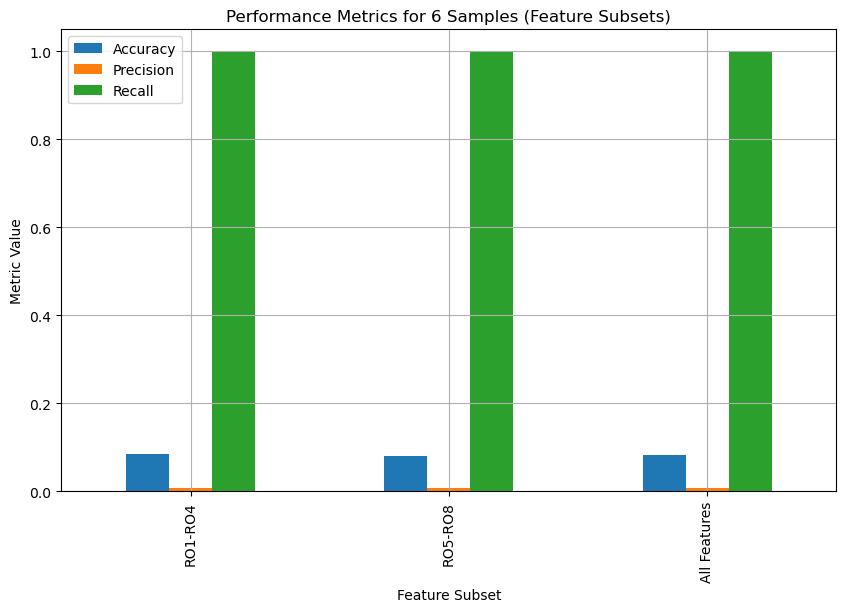


Training Size: 12 Samples (All TF)
Evaluating feature subset: RO1-RO4
Evaluating feature subset: RO5-RO8
Evaluating feature subset: All Features

Summary of Results:
  Feature Subset  Accuracy  Precision  Recall  Training Samples
0        RO1-RO4  0.081181   0.015810     1.0                12
1        RO5-RO8  0.082411   0.015831     1.0                12
2   All Features  0.081181   0.015810     1.0                12


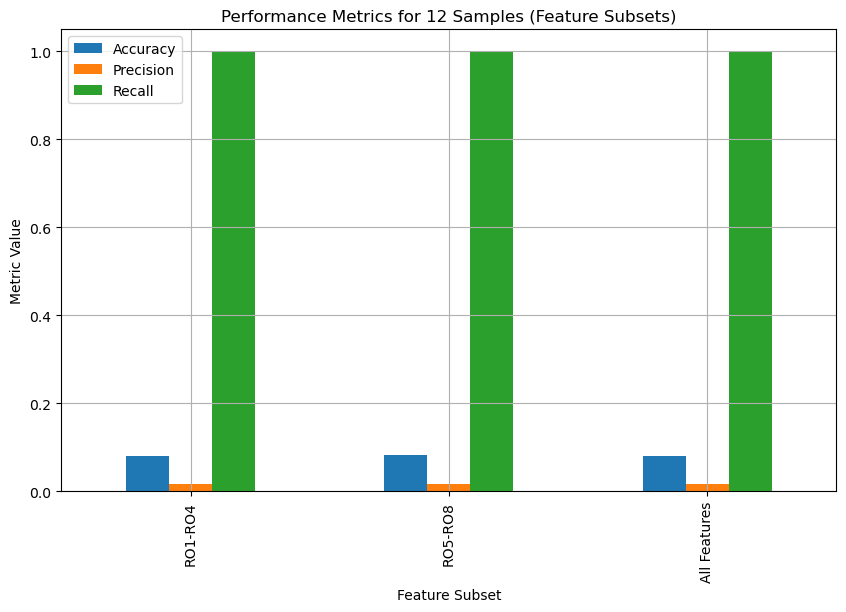


Training Size: 24 Samples (All TF)
Evaluating feature subset: RO1-RO4
Evaluating feature subset: RO5-RO8
Evaluating feature subset: All Features

Summary of Results:
  Feature Subset  Accuracy  Precision    Recall  Training Samples
0        RO1-RO4  0.896380   0.016393  0.041667                24
1        RO5-RO8  0.902622   0.017857  0.041667                24
2   All Features  0.897628   0.016667  0.041667                24


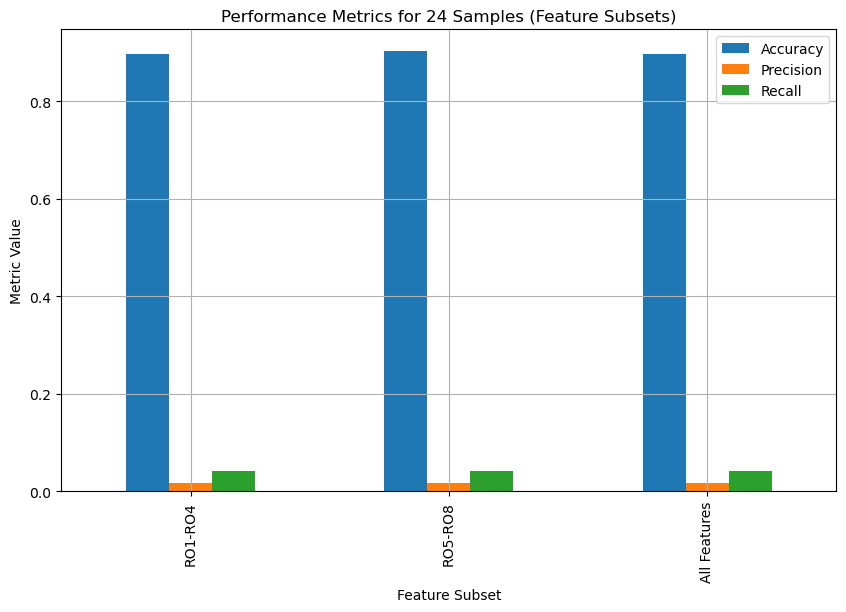


Best Model saved as 'best_trained_model.pkl'

Best Model Details:
Accuracy: 0.9026
Precision: 0.0179
Recall: 0.0417
Training Size: 24
Features Used: RO5-RO8


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import joblib

# Step 1: Load all files and extract data
def load_data(file_pattern="ROFreq/Chip*.xlsx"):
    files = glob(file_pattern)
    data = {}
    for file in files:
        chip_name = file.split("/")[-1].split(".")[0]
        data[chip_name] = pd.read_excel(file, header=None)
    return data

# Step 2: Extract golden data (rows 1 and 25) and prepare training/testing datasets
def prepare_data(data, num_samples):
    tf_samples = []  # Trojan-Free samples (row 1 and 25 from each file)
    test_samples = []  # All other rows for testing
    
    for chip, df in data.items():
        tf_samples.append(df.iloc[0].values)
        tf_samples.append(df.iloc[24].values)
        test_samples.append(df.drop([0, 24]).values)
    
    tf_samples = np.vstack(tf_samples)
    test_samples = np.vstack(test_samples)
    
    # Randomly select num_samples TF samples for training
    rng = np.random.default_rng(seed=42)  # Set seed for reproducibility
    selected_indices = rng.choice(tf_samples.shape[0], size=num_samples, replace=False)
    train_samples = tf_samples[selected_indices]
    remaining_indices = list(set(range(tf_samples.shape[0])) - set(selected_indices))
    test_samples = np.vstack([test_samples, tf_samples[remaining_indices]])
    
    return train_samples, test_samples

# Step 3: Train Isolation Forest and evaluate
def train_and_evaluate(train_samples, test_samples, feature_indices, best_model_data, training_size, subset_name):
    # Subset features
    train_samples = train_samples[:, feature_indices]
    test_samples = test_samples[:, feature_indices]
    
    clf = IsolationForest(random_state=42, contamination=0.2, n_estimators=1500)
    clf.fit(train_samples)
    
    # Predict
    y_pred = clf.predict(test_samples)
    y_true = np.concatenate([np.ones(len(train_samples)), -np.ones(len(test_samples) - len(train_samples))])
    y_pred = np.where(y_pred == 1, 1, -1)
    
    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    
    # Update best model if accuracy is higher
    if accuracy > best_model_data["best_accuracy"]:
        best_model_data["best_accuracy"] = accuracy
        best_model_data["best_precision"] = precision
        best_model_data["best_recall"] = recall
        best_model_data["best_model"] = clf
        best_model_data["training_size"] = training_size
        best_model_data["features_used"] = subset_name

    return accuracy, precision, recall

# Step 4: Experiment with feature subsets
def experiment_with_features(data, num_samples, best_model_data, trials=20):
    feature_subsets = {
        "RO1-RO4": [0, 1, 2, 3],
        "RO5-RO8": [4, 5, 6, 7],
        "All Features": list(range(8))
    }
    
    results = []
    
    for subset_name, feature_indices in feature_subsets.items():
        print(f"Evaluating feature subset: {subset_name}")
        subset_metrics = {"Feature Subset": subset_name}
        
        acc_list, prec_list, rec_list = [], [], []
        for _ in range(trials):
            train_samples, test_samples = prepare_data(data, num_samples)
            acc, prec, rec = train_and_evaluate(train_samples, test_samples, feature_indices, best_model_data, num_samples, subset_name)
            acc_list.append(acc)
            prec_list.append(prec)
            rec_list.append(rec)
        
        # Average metrics
        subset_metrics["Accuracy"] = np.mean(acc_list)
        subset_metrics["Precision"] = np.mean(prec_list)
        subset_metrics["Recall"] = np.mean(rec_list)
        
        results.append(subset_metrics)
    
    return pd.DataFrame(results)

# Additional Visualization: Plot functions
def visualize_results(results_df):
    print("\nBoxplot for Accuracy:")
    plot_boxplots(results_df, "Accuracy")
    
    print("\nBoxplot for Precision:")
    plot_boxplots(results_df, "Precision")
    
    print("\nBoxplot for Recall:")
    plot_boxplots(results_df, "Recall")
    
    print("\nHeatmap of Accuracy:")
    plot_heatmap(results_df, "Accuracy")
    
    print("\nHeatmap of Precision:")
    plot_heatmap(results_df, "Precision")
    
    print("\nHeatmap of Recall:")
    plot_heatmap(results_df, "Recall")
    
    print("\nLine Plot for Metric Trends:")
    plot_metric_trends(results_df)

# Main execution
def main():
    # Load data
    data = load_data()
    
    # Experiment for 6, 12, 24 samples (Case 2: All Trojan-Free)
    sample_groupings = [6, 12, 24]
    final_results = []
    best_model_data = {
        "best_accuracy": 0,
        "best_precision": 0,
        "best_recall": 0,
        "best_model": None,
        "training_size": None,
        "features_used": None
    }

    for num_samples in sample_groupings:
        print(f"\nTraining Size: {num_samples} Samples (All TF)")
        results_df = experiment_with_features(data, num_samples, best_model_data)
        results_df["Training Samples"] = num_samples  # Add training size for context
        final_results.append(results_df)
        
        print("\nSummary of Results:")
        print(results_df)
        
        # Visualize Results
        results_df.set_index("Feature Subset")[["Accuracy", "Precision", "Recall"]].plot(kind="bar", figsize=(10, 6))
        plt.title(f"Performance Metrics for {num_samples} Samples (Feature Subsets)")
        plt.ylabel("Metric Value")
        plt.grid(True)
        plt.show()
    
    # Combine all results
    combined_results_df = pd.concat(final_results, ignore_index=True)
    
    # Save the best model
    joblib.dump(best_model_data["best_model"], "best_trained_model.pkl")
    print("\nBest Model saved as 'best_trained_model.pkl'")
    
    # Print best model details
    print("\nBest Model Details:")
    print(f"Accuracy: {best_model_data['best_accuracy']:.4f}")
    print(f"Precision: {best_model_data['best_precision']:.4f}")
    print(f"Recall: {best_model_data['best_recall']:.4f}")
    print(f"Training Size: {best_model_data['training_size']}")
    print(f"Features Used: {best_model_data['features_used']}")

# Run the main function
main()



Training Size: 6 Samples (All TF)
Evaluating feature subset: RO1-RO4

Confusion Matrix for RO1-RO4 with 6 samples:
[[ 63 750]
 [  0   6]]
TNR: 0.0775, TPR: 1.0000, FPR: 0.9225, FNR: 0.0000
Accuracy: 0.0842, F1 Score: 0.0157

Confusion Matrix for RO1-RO4 with 6 samples:
[[ 63 750]
 [  0   6]]
TNR: 0.0775, TPR: 1.0000, FPR: 0.9225, FNR: 0.0000
Accuracy: 0.0842, F1 Score: 0.0157

Confusion Matrix for RO1-RO4 with 6 samples:
[[ 63 750]
 [  0   6]]
TNR: 0.0775, TPR: 1.0000, FPR: 0.9225, FNR: 0.0000
Accuracy: 0.0842, F1 Score: 0.0157

Confusion Matrix for RO1-RO4 with 6 samples:
[[ 63 750]
 [  0   6]]
TNR: 0.0775, TPR: 1.0000, FPR: 0.9225, FNR: 0.0000
Accuracy: 0.0842, F1 Score: 0.0157

Confusion Matrix for RO1-RO4 with 6 samples:
[[ 63 750]
 [  0   6]]
TNR: 0.0775, TPR: 1.0000, FPR: 0.9225, FNR: 0.0000
Accuracy: 0.0842, F1 Score: 0.0157

Confusion Matrix for RO1-RO4 with 6 samples:
[[ 63 750]
 [  0   6]]
TNR: 0.0775, TPR: 1.0000, FPR: 0.9225, FNR: 0.0000
Accuracy: 0.0842, F1 Score: 0.0157



Confusion Matrix for All Features with 6 samples:
[[ 61 752]
 [  0   6]]
TNR: 0.0750, TPR: 1.0000, FPR: 0.9250, FNR: 0.0000
Accuracy: 0.0818, F1 Score: 0.0157

Confusion Matrix for All Features with 6 samples:
[[ 61 752]
 [  0   6]]
TNR: 0.0750, TPR: 1.0000, FPR: 0.9250, FNR: 0.0000
Accuracy: 0.0818, F1 Score: 0.0157

Confusion Matrix for All Features with 6 samples:
[[ 61 752]
 [  0   6]]
TNR: 0.0750, TPR: 1.0000, FPR: 0.9250, FNR: 0.0000
Accuracy: 0.0818, F1 Score: 0.0157

Confusion Matrix for All Features with 6 samples:
[[ 61 752]
 [  0   6]]
TNR: 0.0750, TPR: 1.0000, FPR: 0.9250, FNR: 0.0000
Accuracy: 0.0818, F1 Score: 0.0157

Confusion Matrix for All Features with 6 samples:
[[ 61 752]
 [  0   6]]
TNR: 0.0750, TPR: 1.0000, FPR: 0.9250, FNR: 0.0000
Accuracy: 0.0818, F1 Score: 0.0157

Confusion Matrix for All Features with 6 samples:
[[ 61 752]
 [  0   6]]
TNR: 0.0750, TPR: 1.0000, FPR: 0.9250, FNR: 0.0000
Accuracy: 0.0818, F1 Score: 0.0157

Confusion Matrix for All Features with 

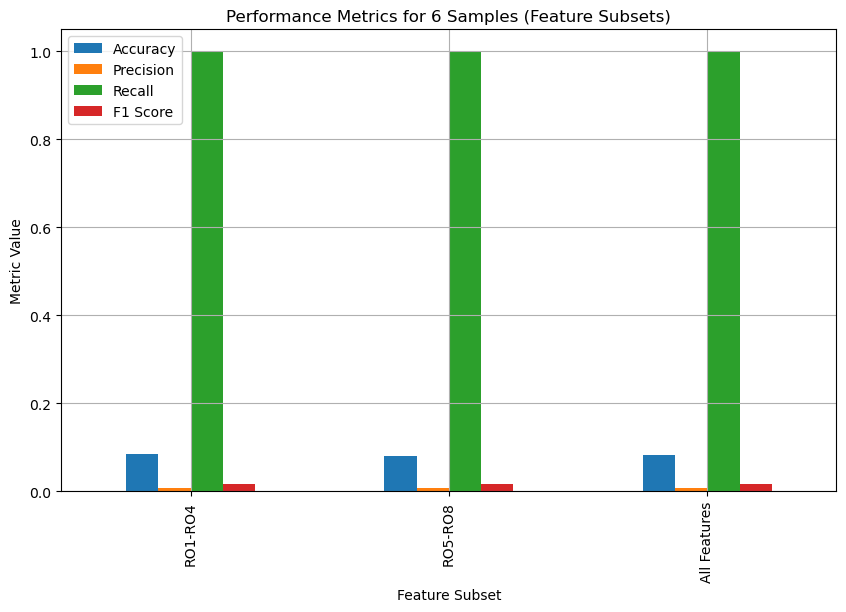


Training Size: 12 Samples (All TF)
Evaluating feature subset: RO1-RO4

Confusion Matrix for RO1-RO4 with 12 samples:
[[ 54 747]
 [  0  12]]
TNR: 0.0674, TPR: 1.0000, FPR: 0.9326, FNR: 0.0000
Accuracy: 0.0812, F1 Score: 0.0311

Confusion Matrix for RO1-RO4 with 12 samples:
[[ 54 747]
 [  0  12]]
TNR: 0.0674, TPR: 1.0000, FPR: 0.9326, FNR: 0.0000
Accuracy: 0.0812, F1 Score: 0.0311

Confusion Matrix for RO1-RO4 with 12 samples:
[[ 54 747]
 [  0  12]]
TNR: 0.0674, TPR: 1.0000, FPR: 0.9326, FNR: 0.0000
Accuracy: 0.0812, F1 Score: 0.0311

Confusion Matrix for RO1-RO4 with 12 samples:
[[ 54 747]
 [  0  12]]
TNR: 0.0674, TPR: 1.0000, FPR: 0.9326, FNR: 0.0000
Accuracy: 0.0812, F1 Score: 0.0311

Confusion Matrix for RO1-RO4 with 12 samples:
[[ 54 747]
 [  0  12]]
TNR: 0.0674, TPR: 1.0000, FPR: 0.9326, FNR: 0.0000
Accuracy: 0.0812, F1 Score: 0.0311

Confusion Matrix for RO1-RO4 with 12 samples:
[[ 54 747]
 [  0  12]]
TNR: 0.0674, TPR: 1.0000, FPR: 0.9326, FNR: 0.0000
Accuracy: 0.0812, F1 Score: 


Confusion Matrix for All Features with 12 samples:
[[ 54 747]
 [  0  12]]
TNR: 0.0674, TPR: 1.0000, FPR: 0.9326, FNR: 0.0000
Accuracy: 0.0812, F1 Score: 0.0311

Confusion Matrix for All Features with 12 samples:
[[ 54 747]
 [  0  12]]
TNR: 0.0674, TPR: 1.0000, FPR: 0.9326, FNR: 0.0000
Accuracy: 0.0812, F1 Score: 0.0311

Confusion Matrix for All Features with 12 samples:
[[ 54 747]
 [  0  12]]
TNR: 0.0674, TPR: 1.0000, FPR: 0.9326, FNR: 0.0000
Accuracy: 0.0812, F1 Score: 0.0311

Confusion Matrix for All Features with 12 samples:
[[ 54 747]
 [  0  12]]
TNR: 0.0674, TPR: 1.0000, FPR: 0.9326, FNR: 0.0000
Accuracy: 0.0812, F1 Score: 0.0311

Confusion Matrix for All Features with 12 samples:
[[ 54 747]
 [  0  12]]
TNR: 0.0674, TPR: 1.0000, FPR: 0.9326, FNR: 0.0000
Accuracy: 0.0812, F1 Score: 0.0311

Confusion Matrix for All Features with 12 samples:
[[ 54 747]
 [  0  12]]
TNR: 0.0674, TPR: 1.0000, FPR: 0.9326, FNR: 0.0000
Accuracy: 0.0812, F1 Score: 0.0311

Confusion Matrix for All Features

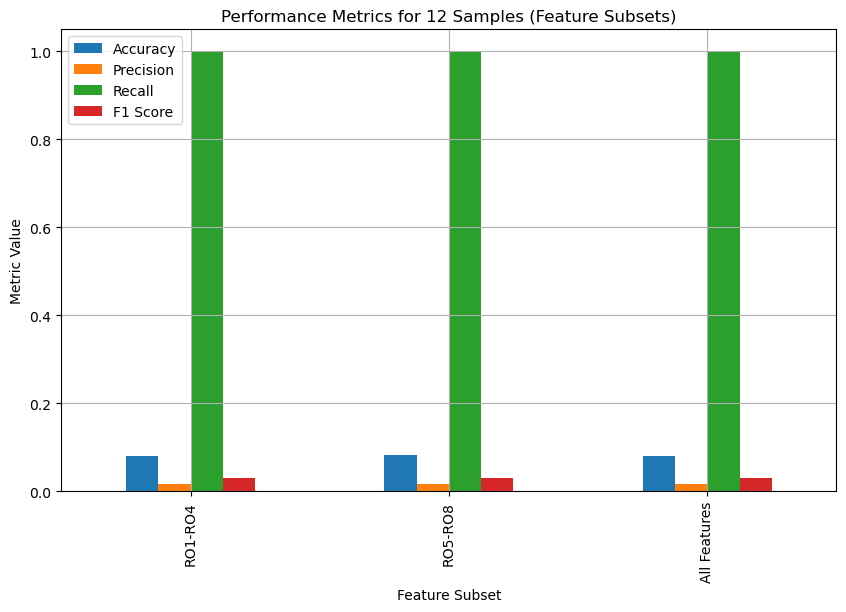


Training Size: 24 Samples (All TF)
Evaluating feature subset: RO1-RO4

Confusion Matrix for RO1-RO4 with 24 samples:
[[717  60]
 [ 23   1]]
TNR: 0.9228, TPR: 0.0417, FPR: 0.0772, FNR: 0.9583
Accuracy: 0.8964, F1 Score: 0.0235

Confusion Matrix for RO1-RO4 with 24 samples:
[[717  60]
 [ 23   1]]
TNR: 0.9228, TPR: 0.0417, FPR: 0.0772, FNR: 0.9583
Accuracy: 0.8964, F1 Score: 0.0235

Confusion Matrix for RO1-RO4 with 24 samples:
[[717  60]
 [ 23   1]]
TNR: 0.9228, TPR: 0.0417, FPR: 0.0772, FNR: 0.9583
Accuracy: 0.8964, F1 Score: 0.0235

Confusion Matrix for RO1-RO4 with 24 samples:
[[717  60]
 [ 23   1]]
TNR: 0.9228, TPR: 0.0417, FPR: 0.0772, FNR: 0.9583
Accuracy: 0.8964, F1 Score: 0.0235

Confusion Matrix for RO1-RO4 with 24 samples:
[[717  60]
 [ 23   1]]
TNR: 0.9228, TPR: 0.0417, FPR: 0.0772, FNR: 0.9583
Accuracy: 0.8964, F1 Score: 0.0235

Confusion Matrix for RO1-RO4 with 24 samples:
[[717  60]
 [ 23   1]]
TNR: 0.9228, TPR: 0.0417, FPR: 0.0772, FNR: 0.9583
Accuracy: 0.8964, F1 Score: 


Confusion Matrix for All Features with 24 samples:
[[718  59]
 [ 23   1]]
TNR: 0.9241, TPR: 0.0417, FPR: 0.0759, FNR: 0.9583
Accuracy: 0.8976, F1 Score: 0.0238

Confusion Matrix for All Features with 24 samples:
[[718  59]
 [ 23   1]]
TNR: 0.9241, TPR: 0.0417, FPR: 0.0759, FNR: 0.9583
Accuracy: 0.8976, F1 Score: 0.0238

Confusion Matrix for All Features with 24 samples:
[[718  59]
 [ 23   1]]
TNR: 0.9241, TPR: 0.0417, FPR: 0.0759, FNR: 0.9583
Accuracy: 0.8976, F1 Score: 0.0238

Confusion Matrix for All Features with 24 samples:
[[718  59]
 [ 23   1]]
TNR: 0.9241, TPR: 0.0417, FPR: 0.0759, FNR: 0.9583
Accuracy: 0.8976, F1 Score: 0.0238

Confusion Matrix for All Features with 24 samples:
[[718  59]
 [ 23   1]]
TNR: 0.9241, TPR: 0.0417, FPR: 0.0759, FNR: 0.9583
Accuracy: 0.8976, F1 Score: 0.0238

Confusion Matrix for All Features with 24 samples:
[[718  59]
 [ 23   1]]
TNR: 0.9241, TPR: 0.0417, FPR: 0.0759, FNR: 0.9583
Accuracy: 0.8976, F1 Score: 0.0238

Confusion Matrix for All Features

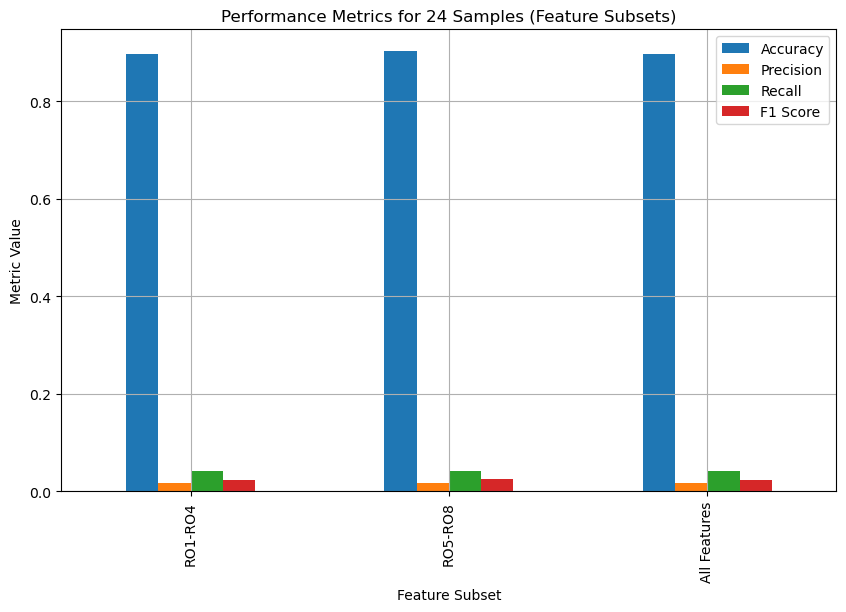


Best Model saved as 'best_trained_model.pkl'

Best Model Details:
Accuracy: 0.9026
Precision: 0.0179
Recall: 0.0417
Training Size: 24
Features Used: RO5-RO8


In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    f1_score,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import joblib

# Step 1: Load all files and extract data
def load_data(file_pattern="ROFreq/Chip*.xlsx"):
    files = glob(file_pattern)
    data = {}
    for file in files:
        chip_name = file.split("/")[-1].split(".")[0]
        data[chip_name] = pd.read_excel(file, header=None)
    return data

# Step 2: Extract golden data (rows 1 and 25) and prepare training/testing datasets
def prepare_data(data, num_samples):
    tf_samples = []  # Trojan-Free samples (row 1 and 25 from each file)
    test_samples = []  # All other rows for testing
    
    for chip, df in data.items():
        tf_samples.append(df.iloc[0].values)
        tf_samples.append(df.iloc[24].values)
        test_samples.append(df.drop([0, 24]).values)
    
    tf_samples = np.vstack(tf_samples)
    test_samples = np.vstack(test_samples)
    
    # Randomly select num_samples TF samples for training
    rng = np.random.default_rng(seed=42)  # Set seed for reproducibility
    selected_indices = rng.choice(tf_samples.shape[0], size=num_samples, replace=False)
    train_samples = tf_samples[selected_indices]
    remaining_indices = list(set(range(tf_samples.shape[0])) - set(selected_indices))
    test_samples = np.vstack([test_samples, tf_samples[remaining_indices]])
    
    return train_samples, test_samples

# Step 3: Train Isolation Forest and evaluate
def train_and_evaluate(train_samples, test_samples, feature_indices, best_model_data, training_size, subset_name):
    # Subset features
    train_samples = train_samples[:, feature_indices]
    test_samples = test_samples[:, feature_indices]
    
    clf = IsolationForest(random_state=42, contamination=0.2, n_estimators=1500)
    clf.fit(train_samples)
    
    # Predict
    y_pred = clf.predict(test_samples)
    y_true = np.concatenate([np.ones(len(train_samples)), -np.ones(len(test_samples) - len(train_samples))])
    y_pred = np.where(y_pred == 1, 1, -1)
    
    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)

    tn, fp, fn, tp = conf_matrix.ravel()
    TNR = tn / (tn + fp) if (tn + fp) > 0 else 0
    TPR = tp / (tp + fn) if (tp + fn) > 0 else 0
    FPR = fp / (fp + tn) if (fp + tn) > 0 else 0
    FNR = fn / (fn + tp) if (fn + tp) > 0 else 0
    f1 = f1_score(y_true, y_pred, pos_label=1)

    print(f"\nConfusion Matrix for {subset_name} with {training_size} samples:")
    print(conf_matrix)
    print(f"TNR: {TNR:.4f}, TPR: {TPR:.4f}, FPR: {FPR:.4f}, FNR: {FNR:.4f}")
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

    # Update best model if accuracy is higher
    if accuracy > best_model_data["best_accuracy"]:
        best_model_data["best_accuracy"] = accuracy
        best_model_data["best_precision"] = precision
        best_model_data["best_recall"] = recall
        best_model_data["best_model"] = clf
        best_model_data["training_size"] = training_size
        best_model_data["features_used"] = subset_name

    return accuracy, precision, recall, f1, conf_matrix

# Step 4: Experiment with feature subsets
def experiment_with_features(data, num_samples, best_model_data, trials=20):
    feature_subsets = {
        "RO1-RO4": [0, 1, 2, 3],
        "RO5-RO8": [4, 5, 6, 7],
        "All Features": list(range(8))
    }
    
    results = []
    
    for subset_name, feature_indices in feature_subsets.items():
        print(f"Evaluating feature subset: {subset_name}")
        subset_metrics = {"Feature Subset": subset_name}
        
        acc_list, prec_list, rec_list, f1_list = [], [], [], []
        for _ in range(trials):
            train_samples, test_samples = prepare_data(data, num_samples)
            acc, prec, rec, f1, conf_matrix = train_and_evaluate(
                train_samples, test_samples, feature_indices, best_model_data, num_samples, subset_name)
            acc_list.append(acc)
            prec_list.append(prec)
            rec_list.append(rec)
            f1_list.append(f1)
        
        # Average metrics
        subset_metrics["Accuracy"] = np.mean(acc_list)
        subset_metrics["Precision"] = np.mean(prec_list)
        subset_metrics["Recall"] = np.mean(rec_list)
        subset_metrics["F1 Score"] = np.mean(f1_list)
        
        results.append(subset_metrics)
    
    return pd.DataFrame(results)

# Main execution
def main():
    # Load data
    data = load_data()
    
    # Experiment for 6, 12, 24 samples (Case 2: All Trojan-Free)
    sample_groupings = [6, 12, 24]
    final_results = []
    best_model_data = {
        "best_accuracy": 0,
        "best_precision": 0,
        "best_recall": 0,
        "best_model": None,
        "training_size": None,
        "features_used": None
    }

    for num_samples in sample_groupings:
        print(f"\nTraining Size: {num_samples} Samples (All TF)")
        results_df = experiment_with_features(data, num_samples, best_model_data)
        results_df["Training Samples"] = num_samples  # Add training size for context
        final_results.append(results_df)
        
        print("\nSummary of Results:")
        print(results_df)
        
        # Visualize Results
        results_df.set_index("Feature Subset")[["Accuracy", "Precision", "Recall", "F1 Score"]].plot(
            kind="bar", figsize=(10, 6))
        plt.title(f"Performance Metrics for {num_samples} Samples (Feature Subsets)")
        plt.ylabel("Metric Value")
        plt.grid(True)
        plt.show()
    
    # Combine all results
    combined_results_df = pd.concat(final_results, ignore_index=True)
    
    # Save the best model
    joblib.dump(best_model_data["best_model"], "best_trained_model.pkl")
    print("\nBest Model saved as 'best_trained_model.pkl'")
    
    # Print best model details
    print("\nBest Model Details:")
    print(f"Accuracy: {best_model_data['best_accuracy']:.4f}")
    print(f"Precision: {best_model_data['best_precision']:.4f}")
    print(f"Recall: {best_model_data['best_recall']:.4f}")
    print(f"Training Size: {best_model_data['training_size']}")
    print(f"Features Used: {best_model_data['features_used']}")

# Run the main function
main()


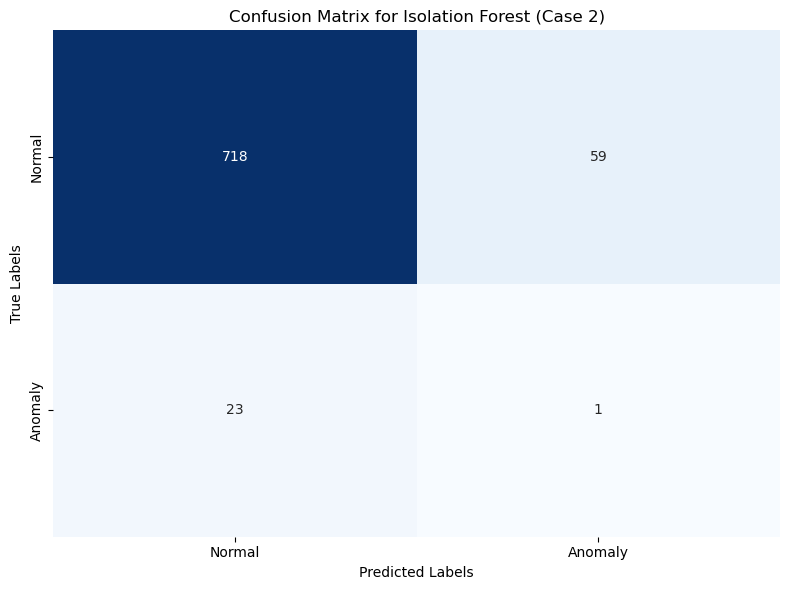

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(conf_matrix, title, output_filename):
    """
    Plots a color-coded confusion matrix and saves it as an image.

    Args:
        conf_matrix (ndarray): Confusion matrix (2x2).
        title (str): Title of the plot.
        output_filename (str): Name of the output file to save the image.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar=False,
        xticklabels=['Normal', 'Anomaly'],
        yticklabels=['Normal', 'Anomaly']
    )
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.savefig(output_filename)
    plt.show()

# Example usage within your code
# Assuming `conf_matrix` is generated from `confusion_matrix()` function
example_conf_matrix = np.array([[718, 59], [23, 1]])  # Replace with your actual confusion matrix
plot_confusion_matrix(
    example_conf_matrix,
    title='Confusion Matrix for Isolation Forest (Case 2)',
    output_filename='confusion_matrix_case2.png'
)
